# ECE590 Smart Cameras Homework 1
## Nathan Inkawhich


**Imports and Mount Drive**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

#import tensorflow as tf
import multiprocessing as mp
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

print(K.tensorflow_backend._get_available_gpus())

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Set path to dataset and plot example images**

In [2]:
# Set path to dataset root directory
DATA_ROOT = "drive/My Drive/INRIAPerson"

# List files in data root directory
os.listdir(DATA_ROOT)

['Test', 'Train']

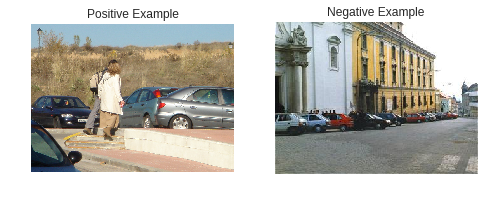

In [3]:
pos_img = plt.imread(DATA_ROOT+"/Test/pos/crop001545.png")
neg_img = plt.imread(DATA_ROOT+"/Test/neg/00001459.png")
plt.subplot(1,2,1)
plt.imshow(pos_img)
plt.title("Positive Example")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(neg_img)
plt.title("Negative Example")
plt.axis("off")
plt.show()

**Training configs**

The default training configs used are batch size 16 and input data size is grayscale 128x128. The choice of grayscale was made mostly for efficiency as processing color images and training many models with color datasets is more time consuming. Since we are not trying to win competitions, the choice of a 1 channel input makes running this notebook faster.

In [0]:
batch_size = 16
input_shape = (1, 128, 128)

**Load datasets**

In [5]:
# Custom dataset example:
#   https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# Initialize train dataset with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(input_shape[1], input_shape[2]),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# Initialize test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_ROOT+"/Test",
    target_size=(input_shape[1], input_shape[2]),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')


Found 1832 images belonging to 2 classes.
Found 749 images belonging to 2 classes.


In [36]:
# Summary of datasets
train_ones = np.count_nonzero(train_generator.classes)
train_total = len(train_generator.classes)
test_ones = np.count_nonzero(test_generator.classes)
test_total = len(test_generator.classes)

print("Train Data Counts:")
print("\tClass 1 (pos): ",train_ones)
print("\tClass 0 (neg): ",train_total-train_ones)
print("\tTotal: ",train_total)

print("Test Data Counts:")
print("\tClass 1 (pos): ",test_ones)
print("\tClass 0 (neg): ",test_total-test_ones)
print("\tTotal: ",test_total)

Train Data Counts:
	Class 1 (pos):  614
	Class 0 (neg):  1218
	Total:  1832
Test Data Counts:
	Class 1 (pos):  288
	Class 0 (neg):  461
	Total:  749


At this point we have created generators for our training and test data. Above are the counts of each class in the training and test splits. Notice, there is an imbalance in the training counts that may bias our predictor towards predicting "neg" because there is about double the number of "neg" examples than "pos" examples. However, without training and evaluating, we have no way to know how much this will impact the performance of the model so we will not subset the dataset in this work.

## Model Performance Versus Model Depth

### Model Definitions

We create 5 different models with 1, 2, 3, 4, and 5 convolutional layers, respectively. To evaluate the impact of depth we fix the classification part of the model so the extracted features from the convolutional layer(s) always go to a single hidden layer with 10 neurons, then to a single output neuron. Because this is a binary problem, we use the sigmoid output activation (which is equivalent to the softmax output with number of classes = 2) and a binary cross entropy loss. In all cases the optimizer is ADAM as this algorithm is known to work well without tuning of the learning parameters and batch size is 16.

Note, as input all models take a 128x128 grayscale image. During training we apply random rotation, random zooming, and random horizontal flipping as data augmentations with the goal of achieving better generalization performance. During testing, no augmentations are applied to the data.

In [0]:
def cnn_1conv():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(5, 5)))

  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_2conv():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_3conv():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_4conv():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-4
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_5conv():
  model = Sequential()
 
  # Conv-1
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-4
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-5
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  #model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Train models with different depths

In [0]:
# Instantiate the different CNNs of different depths
cnn_1L = cnn_1conv()
cnn_2L = cnn_2conv()
cnn_3L = cnn_3conv()
cnn_4L = cnn_4conv()
cnn_5L = cnn_5conv()

In [8]:
cnn_1L.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 32s 278ms/step - loss: 0.5820 - acc: 0.6614 - val_loss: 0.5313 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 28s 248ms/step - loss: 0.5391 - acc: 0.6647 - val_loss: 0.4577 - val_acc: 0.6155
Epoch 3/15
115/115 [==============================] - 28s 243ms/step - loss: 0.5316 - acc: 0.6647 - val_loss: 0.4849 - val_acc: 0.6155
Epoch 4/15
115/115 [==============================] - 28s 247ms/step - loss: 0.5209 - acc: 0.6652 - val_loss: 0.4493 - val_acc: 0.6155
Epoch 5/15
115/115 [==============================] - 28s 246ms/step - loss: 0.5012 - acc: 0.6647 - val_loss: 0.4447 - val_acc: 0.6155
Epoch 6/15
115/115 [==============================] - 28s 241ms/step - loss: 0.5079 - acc: 0.6810 - val_loss: 0.4397 - val_acc: 0.8625
Epoch 7/15
115/115 [==============================] - 28s 244ms/step - loss: 0.4948 - acc: 0.7087 - val_loss: 0.4383 - val_acc: 0.8692
Epoch 8/15
115/115 [==============================] - 2

In [9]:
cnn_2L.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 31s 265ms/step - loss: 0.5950 - acc: 0.6522 - val_loss: 0.5207 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 28s 244ms/step - loss: 0.5091 - acc: 0.6821 - val_loss: 0.4705 - val_acc: 0.8264
Epoch 3/15
115/115 [==============================] - 28s 244ms/step - loss: 0.4976 - acc: 0.7511 - val_loss: 0.4740 - val_acc: 0.8451
Epoch 4/15
115/115 [==============================] - 29s 252ms/step - loss: 0.4841 - acc: 0.7505 - val_loss: 0.4440 - val_acc: 0.8638
Epoch 5/15
115/115 [==============================] - 28s 242ms/step - loss: 0.4783 - acc: 0.7554 - val_loss: 0.4397 - val_acc: 0.8625
Epoch 6/15
115/115 [==============================] - 28s 248ms/step - loss: 0.4714 - acc: 0.7717 - val_loss: 0.4176 - val_acc: 0.8692
Epoch 7/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4899 - acc: 0.7505 - val_loss: 0.4262 - val_acc: 0.8745
Epoch 8/15
115/115 [==============================] - 2

In [10]:
cnn_3L.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 30s 263ms/step - loss: 0.5576 - acc: 0.6951 - val_loss: 0.4930 - val_acc: 0.7597
Epoch 2/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4640 - acc: 0.7331 - val_loss: 0.4045 - val_acc: 0.8331
Epoch 3/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4844 - acc: 0.7299 - val_loss: 0.3741 - val_acc: 0.8545
Epoch 4/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4535 - acc: 0.7630 - val_loss: 0.3713 - val_acc: 0.8558
Epoch 5/15
115/115 [==============================] - 27s 239ms/step - loss: 0.4363 - acc: 0.7908 - val_loss: 0.4072 - val_acc: 0.8491
Epoch 6/15
115/115 [==============================] - 27s 236ms/step - loss: 0.4416 - acc: 0.7918 - val_loss: 0.3542 - val_acc: 0.8705
Epoch 7/15
115/115 [==============================] - 28s 240ms/step - loss: 0.4114 - acc: 0.8174 - val_loss: 0.3271 - val_acc: 0.8665
Epoch 8/15
115/115 [==============================] - 2

In [11]:
cnn_4L.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 30s 260ms/step - loss: 0.5907 - acc: 0.6516 - val_loss: 0.4964 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4939 - acc: 0.7169 - val_loss: 0.4301 - val_acc: 0.8077
Epoch 3/15
115/115 [==============================] - 27s 238ms/step - loss: 0.4764 - acc: 0.7576 - val_loss: 0.4175 - val_acc: 0.8371
Epoch 4/15
115/115 [==============================] - 27s 234ms/step - loss: 0.4448 - acc: 0.7739 - val_loss: 0.3561 - val_acc: 0.8571
Epoch 5/15
115/115 [==============================] - 28s 243ms/step - loss: 0.4287 - acc: 0.7804 - val_loss: 0.3452 - val_acc: 0.8611
Epoch 6/15
115/115 [==============================] - 29s 251ms/step - loss: 0.4042 - acc: 0.8098 - val_loss: 0.3159 - val_acc: 0.8718
Epoch 7/15
115/115 [==============================] - 29s 250ms/step - loss: 0.4003 - acc: 0.7989 - val_loss: 0.3340 - val_acc: 0.8785
Epoch 8/15
115/115 [==============================] - 2

In [12]:
cnn_5L.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 30s 263ms/step - loss: 0.5839 - acc: 0.6614 - val_loss: 0.4769 - val_acc: 0.7904
Epoch 2/15
115/115 [==============================] - 27s 239ms/step - loss: 0.4892 - acc: 0.7571 - val_loss: 0.4378 - val_acc: 0.8131
Epoch 3/15
115/115 [==============================] - 29s 253ms/step - loss: 0.4554 - acc: 0.7734 - val_loss: 0.4274 - val_acc: 0.8264
Epoch 4/15
115/115 [==============================] - 28s 240ms/step - loss: 0.4410 - acc: 0.7967 - val_loss: 0.3615 - val_acc: 0.8451
Epoch 5/15
115/115 [==============================] - 28s 244ms/step - loss: 0.4207 - acc: 0.8065 - val_loss: 0.3300 - val_acc: 0.8571
Epoch 6/15
115/115 [==============================] - 27s 239ms/step - loss: 0.3902 - acc: 0.8212 - val_loss: 0.3347 - val_acc: 0.8772
Epoch 7/15
115/115 [==============================] - 27s 235ms/step - loss: 0.3675 - acc: 0.8359 - val_loss: 0.3346 - val_acc: 0.8531
Epoch 8/15
115/115 [==============================] - 2

### Visualize Performance vs Model Depth

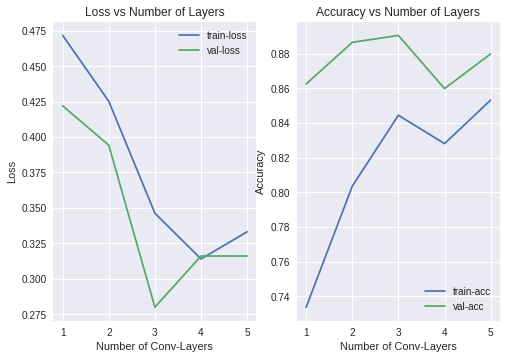

In [15]:
# Performance vs number of layers data
num_layers = [1,2,3,4,5]
train_loss_vs_layers = [cnn_1L.history.history['loss'][-1],
                        cnn_2L.history.history['loss'][-1],
                        cnn_3L.history.history['loss'][-1],
                        cnn_4L.history.history['loss'][-1],
                        cnn_5L.history.history['loss'][-1]]
train_acc_vs_layers = [cnn_1L.history.history['acc'][-1],
                      cnn_2L.history.history['acc'][-1],
                      cnn_3L.history.history['acc'][-1],
                      cnn_4L.history.history['acc'][-1],
                      cnn_5L.history.history['acc'][-1]]
val_loss_vs_layers = [cnn_1L.history.history['val_loss'][-1],
                      cnn_2L.history.history['val_loss'][-1],
                      cnn_3L.history.history['val_loss'][-1],
                      cnn_4L.history.history['val_loss'][-1],
                      cnn_5L.history.history['val_loss'][-1]]
val_acc_vs_layers = [cnn_1L.history.history['val_acc'][-1],
                     cnn_2L.history.history['val_acc'][-1],
                     cnn_3L.history.history['val_acc'][-1],
                     cnn_4L.history.history['val_acc'][-1],
                     cnn_5L.history.history['val_acc'][-1]]

# Plot performance vs number of layers
plt.subplot(1,2,1)
plt.plot(num_layers,train_loss_vs_layers,label='train-loss')
plt.plot(num_layers,val_loss_vs_layers,label='val-loss')
plt.title("Loss vs Number of Layers")
plt.xlabel("Number of Conv-Layers")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(num_layers,train_acc_vs_layers,label='train-acc')
plt.plot(num_layers,val_acc_vs_layers,label='val-acc')
plt.title("Accuracy vs Number of Layers")
plt.xlabel("Number of Conv-Layers")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The loss and accuracy results show some important trends. First, model depth does have a sizeable impact on performance. The 1-conv layer model seems to be too small to properly handle this dataset as shown by the relatively high loss and low accuracy. However, it appears that deeper is not always better as shown by the 3-conv layer model outperforming the 4 and 5 conv layer models in terms of val/test accuracy. This experiment shows that model architecture plays an important role in model performance.

**Note:** From this point forward we will use the 3-conv layer CNN as the baseline model as it has the best test set performance from these experiments.

## Performance versus Training Iterations

In [16]:
# Construct a 3-ConvLayer model
cnn_3L_longtrain = cnn_3conv()
# Train for 100 epochs
cnn_3L_longtrain.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    verbose=1,
    workers=8,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/100
115/115 [==============================] - 32s 278ms/step - loss: 0.6212 - acc: 0.6620 - val_loss: 0.5201 - val_acc: 0.6155
Epoch 2/100
115/115 [==============================] - 29s 253ms/step - loss: 0.5547 - acc: 0.6516 - val_loss: 0.4772 - val_acc: 0.6155
Epoch 3/100
115/115 [==============================] - 28s 243ms/step - loss: 0.5233 - acc: 0.6696 - val_loss: 0.4596 - val_acc: 0.6155
Epoch 4/100
115/115 [==============================] - 29s 249ms/step - loss: 0.5404 - acc: 0.6587 - val_loss: 0.4665 - val_acc: 0.6155
Epoch 5/100
115/115 [==============================] - 28s 247ms/step - loss: 0.5080 - acc: 0.6739 - val_loss: 0.4596 - val_acc: 0.6155
Epoch 6/100
115/115 [==============================] - 28s 241ms/step - loss: 0.5107 - acc: 0.6696 - val_loss: 0.4621 - val_acc: 0.6155
Epoch 7/100
115/115 [==============================] - 28s 246ms/step - loss: 0.5035 - acc: 0.6630 - val_loss: 0.4718 - val_acc: 0.6155
Epoch 8/100
115/115 [===========================

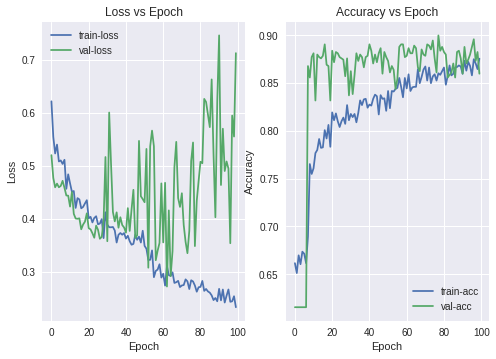

In [19]:
# Plot performance vs training epochs
plt.subplot(1,2,1)
plt.plot(cnn_3L_longtrain.history.history['loss'],label='train-loss')
plt.plot(cnn_3L_longtrain.history.history['val_loss'],label='val-loss')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(cnn_3L_longtrain.history.history['acc'],label='train-acc')
plt.plot(cnn_3L_longtrain.history.history['val_acc'],label='val-acc')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The above figure shows the effect of training time on performance. First, the more training we do the smaller the training loss becomes and the better the training accuracy. This is expected as our objective is an empirical risk minimization on our training set. Second, from the validation loss curve more training does not always lead to better generalization. After about 25 epochs of the val-loss steadily decreasing we see it start to increase which hints that the model may be overfitting the training set.

To get a better idea of the errors the model is making we can now create a confusion matrix for the full test set.

In [20]:
cmat_test_datagen = ImageDataGenerator(rescale=1./255)
cmat_test_generator = cmat_test_datagen.flow_from_directory(
    DATA_ROOT+"/Test",
    target_size=(input_shape[1], input_shape[2]),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)
probabilities = cnn_3L_longtrain.predict_generator(cmat_test_generator, len(cmat_test_generator))

Found 749 images belonging to 2 classes.


In [0]:
# Confusion Matrix Code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[444  17]
 [ 88 200]]


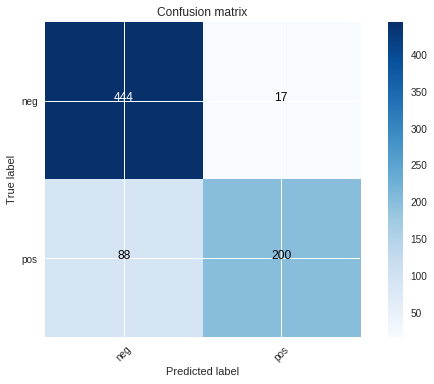

In [33]:
# Turn probabilities into binary predictions
y_pred = probabilities>0.5

from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(cmat_test_generator.classes,y_pred)
plot_confusion_matrix(cmat,['neg','pos'])

The above confusion matrix is generated with the 3 convolutional layer model trained for 100 epochs. Recall, we noticed an imbalance in the training dataset where there was about double the number of "neg" examples than "pos" and we were not sure how this would impact the classifier. From this confusion matrix, we see that this *did* create a biased classifier as the performance on the "neg" examples is higher than on the "pos" examples. However, test performance on the true label "pos" examples is still much greater than random guessing at about 70% compared to 96% on the true label "neg" examples. Overall, the test accuracy of this model is 86%. For future work, a solution would be to either get more "pos" examples or delete some "neg" examples to unbias the training set.

## Debias the Training Set

Here we will debias the training set by removing some "neg" example so there are exactly the same number of "pos" and "neg" samples. Then we will retrain the model and retest.

### Create unbiased training set

In [60]:
unbias_train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

unbias_train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=1,
    shuffle=True,
    class_mode='binary')

num_training_samples = len(unbias_train_generator)
y_full = unbias_train_generator.classes
assert(num_training_samples == len(y_full))


MAX_ZEROS=614
zero_cnt = 0
iter_cnt = 0
X_train = []
Y_train = []
for dat in unbias_train_generator:
  lbl = dat[1]
  if (lbl == 1):
    X_train.append(dat[0][0])
    Y_train.append(dat[1])
  elif (lbl == 0) and (zero_cnt < MAX_ZEROS):
    X_train.append(dat[0][0])
    Y_train.append(dat[1])
    zero_cnt += 1
  
  # Only cycle through train generator once
  iter_cnt += 1
  if iter_cnt >= num_training_samples:
    break
    
    
print("Shape of sample: ",X_train[0].shape)
print("Num training images: ",len(X_train))
print("Num training labels: ",len(Y_train))
print("Num nonzero training labels: ", np.count_nonzero(Y_train))
print("Num zero training labels: ", len(Y_train) - np.count_nonzero(Y_train))


Found 1832 images belonging to 2 classes.
Shape of sample:  (1, 128, 128)
Num training images:  1228
Num training labels:  1228
Num nonzero training labels:  614
Num zero training labels:  614


In [61]:
# Create 3 conv layer model
unbias_cnn_3L = cnn_3conv()
# Fit it with the unbiased training data
unbias_cnn_3L.fit([X_train], [Y_train], batch_size=16, epochs=100, shuffle=True)

Epoch 1/100
1228/1228 [==============================] - 2s 2ms/step - loss: 0.6288 - acc: 0.6352
Epoch 2/100
1228/1228 [==============================] - 1s 830us/step - loss: 0.5697 - acc: 0.7125
Epoch 3/100
1228/1228 [==============================] - 1s 821us/step - loss: 0.5194 - acc: 0.7712
Epoch 4/100
1228/1228 [==============================] - 1s 813us/step - loss: 0.4759 - acc: 0.7899
Epoch 5/100
1228/1228 [==============================] - 1s 807us/step - loss: 0.4705 - acc: 0.7940
Epoch 6/100
1228/1228 [==============================] - 1s 801us/step - loss: 0.4713 - acc: 0.7932
Epoch 7/100
1228/1228 [==============================] - 1s 805us/step - loss: 0.4436 - acc: 0.8233
Epoch 8/100
1228/1228 [==============================] - 1s 785us/step - loss: 0.4303 - acc: 0.8331
Epoch 9/100
1228/1228 [==============================] - 1s 788us/step - loss: 0.4001 - acc: 0.8599
Epoch 10/100
1228/1228 [==============================] - 1s 797us/step - loss: 0.3669 - acc: 0.8607
E

Found 749 images belonging to 2 classes.
Confusion matrix, without normalization
[[419  42]
 [ 52 236]]


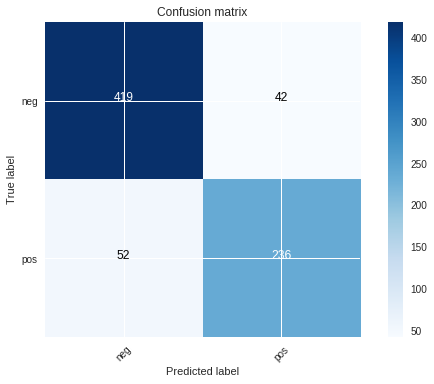

In [63]:
ub_cmat_test_datagen = ImageDataGenerator(rescale=1./255)
ub_cmat_test_generator = ub_cmat_test_datagen.flow_from_directory(
    DATA_ROOT+"/Test",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=16,
    shuffle=False,
    class_mode=None)
# Get predictions for full test set
ub_probabilities = unbias_cnn_3L.predict_generator(ub_cmat_test_generator, len(ub_cmat_test_generator))
# Turn probabilities into binary predictions
y_pred_ub = ub_probabilities>0.5
cmat_ub = confusion_matrix(ub_cmat_test_generator.classes,y_pred_ub)
plot_confusion_matrix(cmat_ub,['neg','pos'])

Now we can compare this confusion matrix to the previous one from the CNN trained with a biased dataset. We see that the errors are more evenly distributed between the two classes instead of most of the error being concentrated on the positive class case. However, notice this classifier is not significantly better than the previous one as the test accuracy is 87.84% (as opposed to 86% previously). Unfortunately, we had to remove a significant amount of data from the training set which may be the reason why we dont see a very large increase in accuracy.

## Performance Versus Batch Size

To see the effects of batch size we choose the 3 conv layer model and train it several times using different batch sizes. Obviously the smallest batch size is 1 which corresponds to true SGD and the largest will be dictated by the GPU's memory.

In [64]:
# Initialize test dataset. We can use this one for all models
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_ROOT+"/Test",
    target_size=(input_shape[1], input_shape[2]),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 749 images belonging to 2 classes.


In [65]:
##########################
batch_size=1
##########################

# Init training data generator with batch size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

# Train model
cnn_3L_bs1 = cnn_3conv()
cnn_3L_bs1.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=8,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Found 1832 images belonging to 2 classes.
Epoch 1/15
1832/1832 [==============================] - 43s 24ms/step - loss: 0.5811 - acc: 0.6648 - val_loss: 0.4803 - val_acc: 0.6155
Epoch 2/15
1832/1832 [==============================] - 42s 23ms/step - loss: 0.5219 - acc: 0.6850 - val_loss: 0.4527 - val_acc: 0.8678
Epoch 3/15
1832/1832 [==============================] - 41s 23ms/step - loss: 0.5015 - acc: 0.7396 - val_loss: 0.4571 - val_acc: 0.8278
Epoch 4/15
1832/1832 [==============================] - 42s 23ms/step - loss: 0.4789 - acc: 0.7626 - val_loss: 0.4982 - val_acc: 0.7757
Epoch 5/15
1832/1832 [==============================] - 41s 22ms/step - loss: 0.4728 - acc: 0.7773 - val_loss: 0.4061 - val_acc: 0.8585
Epoch 6/15
1832/1832 [==============================] - 40s 22ms/step - loss: 0.4326 - acc: 0.8160 - val_loss: 0.3760 - val_acc: 0.8558
Epoch 7/15
1832/1832 [==============================] - 41s 22ms/step - loss: 0.4322 - acc: 0.8166 - val_loss: 0.3643 - val_acc: 0.8705
Epoch 

In [66]:
##########################
batch_size=32
##########################

# Init training data generator with batch size
train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

# Train model
cnn_3L_bs32 = cnn_3conv()
cnn_3L_bs32.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=8,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Found 1832 images belonging to 2 classes.
Epoch 1/15
58/58 [==============================] - 32s 554ms/step - loss: 0.5954 - acc: 0.6601 - val_loss: 0.5104 - val_acc: 0.6155
Epoch 2/15
58/58 [==============================] - 28s 483ms/step - loss: 0.5576 - acc: 0.6643 - val_loss: 0.4915 - val_acc: 0.6155
Epoch 3/15
58/58 [==============================] - 28s 480ms/step - loss: 0.5342 - acc: 0.6643 - val_loss: 0.4765 - val_acc: 0.6155
Epoch 4/15
58/58 [==============================] - 28s 475ms/step - loss: 0.5200 - acc: 0.6659 - val_loss: 0.4594 - val_acc: 0.6155
Epoch 5/15
58/58 [==============================] - 28s 480ms/step - loss: 0.5038 - acc: 0.6643 - val_loss: 0.4776 - val_acc: 0.6155
Epoch 6/15
58/58 [==============================] - 27s 470ms/step - loss: 0.5109 - acc: 0.6628 - val_loss: 0.4559 - val_acc: 0.6155
Epoch 7/15
58/58 [==============================] - 27s 471ms/step - loss: 0.4940 - acc: 0.7171 - val_loss: 0.4561 - val_acc: 0.8531
Epoch 8/15
58/58 [=========

In [67]:
##########################
batch_size=128
##########################

# Init training data generator with batch size
train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

# Train model
cnn_3L_bs128 = cnn_3conv()
cnn_3L_bs128.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=8,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Found 1832 images belonging to 2 classes.
Epoch 1/15
15/15 [==============================] - 41s 3s/step - loss: 0.6324 - acc: 0.6468 - val_loss: 0.5812 - val_acc: 0.6155
Epoch 2/15
15/15 [==============================] - 27s 2s/step - loss: 0.5484 - acc: 0.6674 - val_loss: 0.5201 - val_acc: 0.6155
Epoch 3/15
15/15 [==============================] - 29s 2s/step - loss: 0.5052 - acc: 0.6664 - val_loss: 0.4697 - val_acc: 0.6155
Epoch 4/15
15/15 [==============================] - 27s 2s/step - loss: 0.4921 - acc: 0.6631 - val_loss: 0.4605 - val_acc: 0.6155
Epoch 5/15
15/15 [==============================] - 28s 2s/step - loss: 0.4799 - acc: 0.7625 - val_loss: 0.4716 - val_acc: 0.7850
Epoch 6/15
15/15 [==============================] - 26s 2s/step - loss: 0.5013 - acc: 0.7677 - val_loss: 0.4546 - val_acc: 0.8238
Epoch 7/15
15/15 [==============================] - 28s 2s/step - loss: 0.4806 - acc: 0.7551 - val_loss: 0.4542 - val_acc: 0.8358
Epoch 8/15
15/15 [==============================

Overall, the experiments on batch sizes in this particular experiment do not tell us much. This is mostly because the GPU we are using is relatively lightweight so we do not see huge gains in throughput with larger batches. However, we see some speedup in the epoch times with larger batch size. At size=1 an epoch takes about 40s and at size=32 an epoch takes about 28s. This is because we are taking better advantage of the parallel processing provided by GPUs. Unfortunately at larger batch sizes (size=128) on this machine we do not see speedups but with a better GPU we would.

## Performance Versus Kernel Size

In [0]:
def cnn_3conv_k5():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (5, 5), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (5, 5)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (5, 5)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_3conv_k11():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (11, 11), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (11, 11)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (11, 11)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def cnn_3conv_k32():
  model = Sequential()
  
  # Conv-1
  model.add(Conv2D(16, (32, 32), padding='same',input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Conv-2
  model.add(Conv2D(16, (32, 32), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Conv-3
  model.add(Conv2D(32, (32, 32), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [70]:
# Init training data generator with batch size
train_generator = train_datagen.flow_from_directory(
    DATA_ROOT+"/Train",
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=16,
    shuffle=True,
    class_mode='binary')

##########################
# Kernel Size: 5x5
##########################
cnn_3L_k5 = cnn_3conv_k5()
cnn_3L_k5.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Found 1832 images belonging to 2 classes.
Epoch 1/15
115/115 [==============================] - 31s 271ms/step - loss: 0.6149 - acc: 0.6598 - val_loss: 0.5055 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 28s 246ms/step - loss: 0.5073 - acc: 0.6663 - val_loss: 0.4919 - val_acc: 0.7957
Epoch 3/15
115/115 [==============================] - 28s 247ms/step - loss: 0.5115 - acc: 0.7375 - val_loss: 0.4781 - val_acc: 0.7931
Epoch 4/15
115/115 [==============================] - 28s 241ms/step - loss: 0.4883 - acc: 0.7652 - val_loss: 0.4652 - val_acc: 0.8278
Epoch 5/15
115/115 [==============================] - 29s 252ms/step - loss: 0.4830 - acc: 0.7723 - val_loss: 0.4790 - val_acc: 0.8371
Epoch 6/15
115/115 [==============================] - 28s 245ms/step - loss: 0.4830 - acc: 0.7755 - val_loss: 0.4214 - val_acc: 0.8144
Epoch 7/15
115/115 [==============================] - 29s 248ms/step - loss: 0.4476 - acc: 0.7913 - val_loss: 0.4311 - val_acc: 0.8318
Epoch 8/15
11

In [71]:
##########################
# Kernel Size: 11x11
##########################
cnn_3L_k11 = cnn_3conv_k11()
cnn_3L_k11.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 32s 283ms/step - loss: 0.6181 - acc: 0.6598 - val_loss: 0.5171 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 28s 246ms/step - loss: 0.5248 - acc: 0.6658 - val_loss: 0.5821 - val_acc: 0.6155
Epoch 3/15
115/115 [==============================] - 28s 244ms/step - loss: 0.5280 - acc: 0.6723 - val_loss: 0.5458 - val_acc: 0.7730
Epoch 4/15
115/115 [==============================] - 27s 237ms/step - loss: 0.5313 - acc: 0.7114 - val_loss: 0.5312 - val_acc: 0.7583
Epoch 5/15
115/115 [==============================] - 28s 241ms/step - loss: 0.5341 - acc: 0.7391 - val_loss: 0.4939 - val_acc: 0.8077
Epoch 6/15
115/115 [==============================] - 28s 244ms/step - loss: 0.4725 - acc: 0.7880 - val_loss: 0.4993 - val_acc: 0.7891
Epoch 7/15
115/115 [==============================] - 28s 246ms/step - loss: 0.4862 - acc: 0.7641 - val_loss: 0.4841 - val_acc: 0.7944
Epoch 8/15
115/115 [==============================] - 2

In [82]:
##########################
# Kernel Size: 32x32
##########################
cnn_3L_k32 = cnn_3conv_k32()
cnn_3L_k32.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    verbose=1,
    workers=4,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/15
115/115 [==============================] - 47s 413ms/step - loss: 0.6732 - acc: 0.6625 - val_loss: 0.6663 - val_acc: 0.6155
Epoch 2/15
115/115 [==============================] - 30s 262ms/step - loss: 0.6702 - acc: 0.6592 - val_loss: 0.6689 - val_acc: 0.6155
Epoch 3/15
115/115 [==============================] - 30s 259ms/step - loss: 0.6558 - acc: 0.6620 - val_loss: 0.6666 - val_acc: 0.6155
Epoch 4/15
115/115 [==============================] - 30s 260ms/step - loss: 0.6512 - acc: 0.6739 - val_loss: 0.6662 - val_acc: 0.6155
Epoch 5/15
115/115 [==============================] - 31s 267ms/step - loss: 0.6545 - acc: 0.6554 - val_loss: 0.6667 - val_acc: 0.6155
Epoch 6/15
115/115 [==============================] - 30s 258ms/step - loss: 0.6428 - acc: 0.6739 - val_loss: 0.6667 - val_acc: 0.6155
Epoch 7/15
115/115 [==============================] - 29s 254ms/step - loss: 0.6488 - acc: 0.6669 - val_loss: 0.6662 - val_acc: 0.6155
Epoch 8/15
115/115 [==============================] - 2

From experiments with different kernel sizes we an interesting trend. As kernel size increases (starting at 3x3), test accuracy decreases. At k=3x3 the final test accuracy is 89%, at k=5x5 final test accuracy is 84.38%, at k=11x11 final test accuracy is 82.51%, and at k=32x32 final test accuracy is 61.55% (random). This is attributed to the size of features the model is learning. For this dataset, it appears that the network works best when looking for smaller sized features. Also, when the kernel gets too big, the model does not learn at all.